<a href="https://colab.research.google.com/github/soucs/ac-gans/blob/main/ac_gans_msssim_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
from torchvision.datasets import CIFAR10

In [ ]:
# Preprocessing transforms to apply on data
transform = Compose([ToTensor(),
                     Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

batch_size = 100

train = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create Dataloader
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 80653112.37it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
num_classes = 10
batch_size = 100
latent_size = 100

# Function to denormalize [-1,1] -> [0,1]
def denorm(x):
  out = (x + 1) / 2
  return out.clamp(0, 1)

# Get random noise input vector (latent_space_randn + one_hot_label)
def get_z(classes):
  z = torch.randn(batch_size, latent_size)
  y = one_hot(classes.reshape(batch_size), num_classes)
  z = torch.cat([z, y], dim=1).reshape(-1,110,1,1)
  return z

In [ ]:
# Discriminator network
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    def discriminator_block(inp, out, stride, bn=True):
      block = [nn.Conv2d(inp, out, 3, stride, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.5)]
      if bn:
        block.append(nn.BatchNorm2d(out, 0.8))
      return block
    # Common layers
    self.common = nn.Sequential(*discriminator_block(3, 16, 2, bn=False),
                                *discriminator_block(16, 32, 1),
                                *discriminator_block(32, 64, 2),
                                *discriminator_block(64, 128, 1),
                                *discriminator_block(128, 256, 2),
                                *discriminator_block(256, 512, 1))

    # Real/Fake classifier layer
    self.discrim = nn.Sequential(nn.Linear(512*4*4, 1),
                                 nn.Sigmoid())
    # Auxiliary classifier (classes) layer
    self.auxil = nn.Sequential(nn.Linear(512*4*4, 10),
                               nn.Softmax(dim=1))
  def forward(self, input): # input = images (batch_size, 3, 32, 32)
    hid_out = self.common(input)
    hid_out = hid_out.view(hid_out.size(0), -1)
    rf_out = self.discrim(hid_out)
    aux_out = self.auxil(hid_out)
    return rf_out, aux_out

# Generator network
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    def generator_block(inp, out, nonlin='relu', bn=True):
      block = [nn.ConvTranspose2d(inp, out, 5, 2, 1)]
      if nonlin == 'tanh':
        block.append(nn.Tanh())
      else:
        block.append(nn.ReLU())
      if bn:
          block.append(nn.BatchNorm2d(out, 0.8))
      return block
    self.gen = nn.Sequential(*generator_block(110,384),
                             *generator_block(384,192),
                             *generator_block(192,96),
                             *generator_block(96,3, nonlin='tanh', bn=False),
                             nn.UpsamplingBilinear2d((32,32)))
  def forward(self, input): # input = classes (batch_size)
    z = get_z(input) # z = latent space (batch_size, 110, 1, 1)
    fake_img = self.gen(z)
    return fake_img

In [ ]:
D = Discriminator()
G = Generator()

criterion = nn.BCELoss()
aux_criterion = nn.CrossEntropyLoss()

d_optimizer = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

def train_discriminator(images,classes):
    real_labels = torch.ones(batch_size,1)
    fake_labels = torch.zeros(batch_size,1)

    # Get loss for real/fake and classes with real images
    rf_out, aux_out = D(images)
    d_loss_real = criterion(rf_out, real_labels)
    d_loss_rclass = aux_criterion(aux_out, classes)

    # Get loss for real/fake and classes with fake images
    fake_images = G(classes)
    rf_out, aux_out = D(fake_images)
    d_loss_fake = criterion(rf_out, fake_labels)
    d_loss_fclass = aux_criterion(aux_out, classes)

    # Combine losses
    Ls = d_loss_real + d_loss_fake
    Lc = d_loss_rclass + d_loss_fclass
    d_loss = Lc + Ls

    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    return d_loss

def train_generator(classes):
    real_labels = torch.ones(batch_size,1)

    fake_images = G(classes)
    rf_out, aux_out = D(fake_images)

    # Get loss of real/fake and classes with fake images
    g_loss_fake = criterion(rf_out, real_labels)
    g_loss_fclass = aux_criterion(aux_out, classes)

    # Combine losses
    g_loss = g_loss_fake + g_loss_fclass

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss

def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

Saving fake_images-0000.png


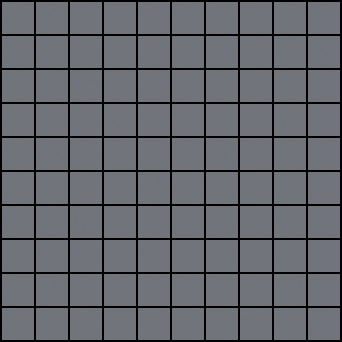

In [ ]:
# CODE BLOCK FOR SAVING GENERATED IMAGES
import os
from IPython.display import Image
from torchvision.utils import save_image

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

for i, classes in train_dl:
    # sample_vectors = get_z(classes)
    break

def save_fake_images(index):
    fake_images = G(classes)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# # Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
# Train GAN for given no.of epochs
num_epochs = 5
total_step = len(train_dl)

for epoch in range(num_epochs):
    for i, (images, classes) in enumerate(train_dl):
      if i==20:
        break
      d_loss = train_discriminator(images, classes)
      g_loss = train_generator(classes)
    print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))
    save_fake_images(epoch+1)

Epoch [1/5], Step [21/500], d_loss: 4.9104, g_loss: 2.2628
Saving fake_images-0001.png
Epoch [2/5], Step [21/500], d_loss: 5.0782, g_loss: 2.2269
Saving fake_images-0002.png
Epoch [3/5], Step [21/500], d_loss: 4.9315, g_loss: 2.1965
Saving fake_images-0003.png
Epoch [4/5], Step [21/500], d_loss: 5.0489, g_loss: 2.2647
Saving fake_images-0004.png
Epoch [5/5], Step [21/500], d_loss: 4.9489, g_loss: 2.2226
Saving fake_images-0005.png


In [ ]:
# CODE BLOCK TO CREATE VIDEO OF TRAINING
import cv2
from IPython.display import FileLink

vid_fname = 'cifar_gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('cifar_gans_training.mp4')

/content/cifar_gans_training.mp4

In [ ]:
# import shutil
# shutil.make_archive('generated_imgs', 'zip', 'samples')

'/content/generated_imgs.zip'

# MS-SSIM

In [ ]:
!pip install pytorch-msssim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_msssim import ssim, ms_ssim
from torchvision.transforms import Resize
# SSIM = [-1,1], MS-SSIM = [0,1] (1 is perfect similarity, 0 is no similarity)


# Since image size must be larger than 160
# to calculate MS-SSIM (downsampling op)
resize = Resize(200, antialias=False)

# Between original images and generated image
for imgs, classes in train_dl:
  X = resize(denorm(imgs))
  Y = resize(denorm(G(classes)))
  break

ssim_score = ssim(X, Y, data_range=1, size_average=True)
ms_ssim_score = ms_ssim( X, Y, data_range=1, size_average=True)
print('Original and Fake Similarity:')
print('SSIM: {0:.3f}; MS-SSIM: {0:.3f}'.format(ssim_score, ms_ssim_score))

# Between two sets of generated images (same classes)
for imgs, classes in train_dl:
  X = resize(G(classes))
  Y = resize(G(classes))
  break

ssim_score = ssim(X, Y, data_range=1, size_average=True)
ms_ssim_score = ms_ssim( X, Y, data_range=1, size_average=True)
print('Generated Images Similarity:')
print('SSIM: {0:.3f}; MS-SSIM: {0:.3f}'.format(ssim_score, ms_ssim_score))

Original and Fake Similarity:
SSIM: 0.366; MS-SSIM: 0.366
Generated Images Similarity:
SSIM: 0.172; MS-SSIM: 0.172
